In [ ]:
!pip install --upgrade --quiet transformers datasets accelerate evaluate scikit-learn


In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import Counter


In [ ]:

dataset = load_dataset("dair-ai/emotion")
print(dataset)

print("\nSample example from train:")
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Sample example from train:
{'text': 'i didnt feel humiliated', 'label': 0}


In [ ]:

label_feature = dataset["train"].features["label"]
num_labels = label_feature.num_classes
label_names = label_feature.names

print("Number of labels:", num_labels)
print("Label names:", label_names)

train_labels = [ex["label"] for ex in dataset["train"]]
label_counts = Counter(train_labels)

print("\nLabel distribution (train):")
for idx, count in sorted(label_counts.items()):
    print(f"{idx} - {label_names[idx]}: {count}")


Number of labels: 6
Label names: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Label distribution (train):
0 - sadness: 4666
1 - joy: 5362
2 - love: 1304
3 - anger: 2159
4 - fear: 1937
5 - surprise: 572


In [ ]:

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

encoded_dataset = dataset.map(tokenize_function, batched=True)

# rename label -> labels for Trainer
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

train_dataset = encoded_dataset["train"]
val_dataset   = encoded_dataset["validation"]
test_dataset  = encoded_dataset["test"]


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:

id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(
        predictions=preds,
        references=labels
    )["accuracy"]

    f1_macro = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]

    return {"accuracy": acc, "f1_macro": f1_macro}


In [ ]:
batch_size = 16

import os
os.environ["WANDB_DISABLED"] = "true"


training_args = TrainingArguments(
    output_dir="./emotion-distilbert",

    do_train=True,
    do_eval=True,           # allows Trainer.evaluate()

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,

    # these are supported in old versions:
    logging_steps=100,
    save_steps=1000
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2721217396.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
trainer.save_model("./emotion-distilbert-best")

print("\nTraining finished.")


Step,Training Loss
100,1.431400
200,0.876300
300,0.544000
400,0.403000
500,0.340700
600,0.280000
700,0.246300
800,0.245900
900,0.235300
1000,0.227900



Training finished.


In [ ]:
print("Validation metrics:")
val_metrics = trainer.evaluate(eval_dataset=val_dataset)
print(val_metrics)

print("\nTest metrics:")
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(test_metrics)

Validation metrics:


{'eval_loss': 0.15671053528785706, 'eval_accuracy': 0.937, 'eval_f1_macro': 0.9109530068333296, 'eval_runtime': 7.3701, 'eval_samples_per_second': 271.367, 'eval_steps_per_second': 16.96, 'epoch': 3.0}

Test metrics:
{'eval_loss': 0.17885130643844604, 'eval_accuracy': 0.9255, 'eval_f1_macro': 0.8776590126092124, 'eval_runtime': 7.538, 'eval_samples_per_second': 265.322, 'eval_steps_per_second': 16.583, 'epoch': 3.0}



Classification report (test set):
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.95      0.94      0.95       695
        love       0.82      0.82      0.82       159
       anger       0.92      0.92      0.92       275
        fear       0.88      0.92      0.90       224
    surprise       0.73      0.70      0.71        66

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



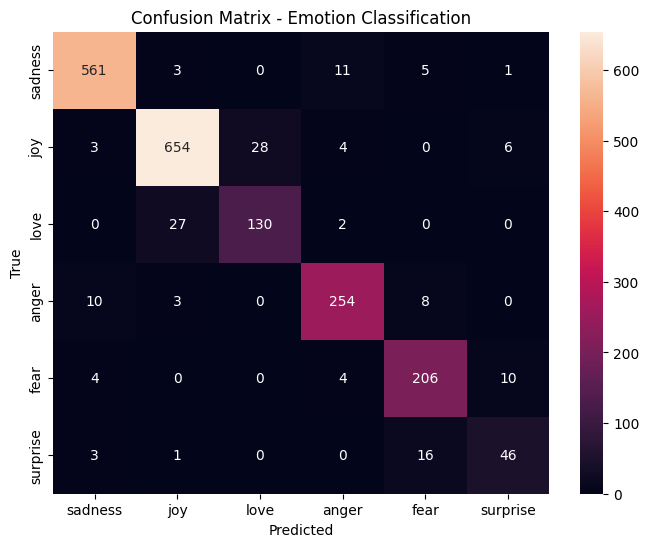

In [ ]:

predictions = trainer.predict(test_dataset)
test_logits = predictions.predictions
test_labels = predictions.label_ids
test_preds = np.argmax(test_logits, axis=-1)

print("\nClassification report (test set):")
print(classification_report(test_labels, test_preds, target_names=label_names))

# Confusion matrix (optional)
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Emotion Classification")
plt.show()


In [ ]:
import torch

def predict_emotion(texts):
    """
    texts: list of strings
    returns: list of (text, predicted_label)
    """
    model.eval()  # put model in eval mode

    # Get the device of the model (cpu or cuda)
    device = next(model.parameters()).device

    # Tokenize on CPU then move tensors to the model's device
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).cpu().tolist()  # move back to CPU for Python

    results = []
    for text, idx in zip(texts, preds):
        emotion = label_names[idx]   # or id2label[idx] if you created that dict
        results.append((text, emotion))
    return results

# Test examples (same as step 14)
examples = [
    "I am so happy today! Everything is going great.",
    "I feel really sad and alone.",
    "This makes me so angry!",
    "Wow, I didn't expect that at all!"
]

for text, emotion in predict_emotion(examples):
    print(f"Text: {text}\nPredicted emotion: {emotion}\n")


Text: I am so happy today! Everything is going great.
Predicted emotion: joy

Text: I feel really sad and alone.
Predicted emotion: sadness

Text: This makes me so angry!
Predicted emotion: anger

Text: Wow, I didn't expect that at all!
Predicted emotion: joy



In [ ]:
tokenizer.save_pretrained("./emotion-distilbert-best")
model.save_pretrained("./emotion-distilbert-best")

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions on test set again (in case you ran this earlier, it's fine to repeat)
predictions = trainer.predict(test_dataset)
test_logits = predictions.predictions
test_labels = predictions.label_ids
test_preds  = np.argmax(test_logits, axis=-1)

# Collect misclassified examples
wrong_examples = []
for i, (true, pred) in enumerate(zip(test_labels, test_preds)):
    if true != pred:
        text = dataset["test"][i]["text"]
        true_label = label_names[true]
        pred_label = label_names[pred]
        wrong_examples.append((text, true_label, pred_label))

# Show first 10 misclassified examples
print(f"Number of misclassified examples: {len(wrong_examples)}\n")
for i, (text, true_label, pred_label) in enumerate(wrong_examples[:10]):
    print(f"Example {i+1}:")
    print(f"Text       : {text}")
    print(f"True label : {true_label}")
    print(f"Pred label : {pred_label}")
    print("-" * 80)


Number of misclassified examples: 149

Example 1:
Text       : i don t feel particularly agitated
True label : fear
Pred label : anger
--------------------------------------------------------------------------------
Example 2:
Text       : i feel a bit stressed even though all the things i have going on are fun
True label : anger
Pred label : sadness
--------------------------------------------------------------------------------
Example 3:
Text       : i am right handed however i play billiards left handed naturally so me trying to play right handed feels weird
True label : surprise
Pred label : fear
--------------------------------------------------------------------------------
Example 4:
Text       : i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love
True label : joy
Pred label : love
--------------------------------------------------------------------------------
Example 5:
Text       : i was feeling weird the other day and 

In [ ]:
# Collect correctly classified examples
correct_examples = []
for i, (true, pred) in enumerate(zip(test_labels, test_preds)):
    if true == pred:
        text = dataset["test"][i]["text"]
        true_label = label_names[true]
        pred_label = label_names[pred]
        correct_examples.append((text, true_label, pred_label))

# Show first 10 correctly classified examples
print(f"Number of correctly classified examples: {len(correct_examples)}\n")
for i, (text, true_label, pred_label) in enumerate(correct_examples[:10]):
    print(f"Example {i+1}:")
    print(f"Text       : {text}")
    print(f"True label : {true_label}")
    print(f"Pred label : {pred_label}")
    print("-" * 80)


Number of correctly classified examples: 1851

Example 1:
Text       : im feeling rather rotten so im not very ambitious right now
True label : sadness
Pred label : sadness
--------------------------------------------------------------------------------
Example 2:
Text       : im updating my blog because i feel shitty
True label : sadness
Pred label : sadness
--------------------------------------------------------------------------------
Example 3:
Text       : i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True label : sadness
Pred label : sadness
--------------------------------------------------------------------------------
Example 4:
Text       : i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
True label : joy
Pred label : joy
--------------------------------------------------------------------------------
Example 5:
Text       : i was feeling a little vain when i 

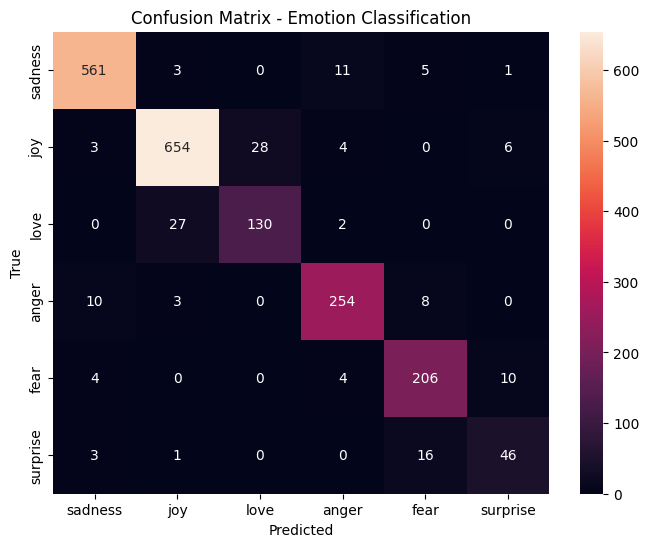

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Emotion Classification")
plt.show()


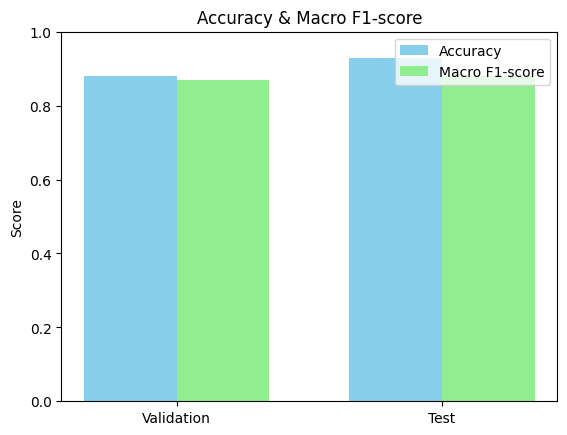

In [ ]:
import matplotlib.pyplot as plt

# Metrics
categories = ['Validation', 'Test']
accuracy = [0.88, 0.93]
f1_macro = [0.87, 0.88]

# Set bar width
bar_width = 0.35
x = range(len(categories))

# Plot bars
plt.bar([i - bar_width/2 for i in x], accuracy, width=bar_width, label='Accuracy', color='skyblue')
plt.bar([i + bar_width/2 for i in x], f1_macro, width=bar_width, label='Macro F1-score', color='lightgreen')

# Labels and title
plt.xticks(x, categories)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Accuracy & Macro F1-score')
plt.legend()

# Show chart
plt.show()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load saved model & tokenizer
model_name_or_path = "./emotion-distilbert-best"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Emotion labels
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']  # from your dataset

# Real-time loop
while True:
    text = input("Enter a sentence (or 'quit' to exit): ")
    if text.lower() == "quit":
        break

    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        emotion = label_names[pred_idx]

    print(f"Predicted emotion: {emotion}\n")

Enter a sentence (or 'quit' to exit): Wow, I didn’t expect that at all!
Predicted emotion: surprise

Enter a sentence (or 'quit' to exit): My heart feels full when I’m with my family.
Predicted emotion: joy

Enter a sentence (or 'quit' to exit): Today was the best day ever, I’m so happy!
Predicted emotion: joy

Enter a sentence (or 'quit' to exit): I feel so lonely and down today.
Predicted emotion: sadness

Enter a sentence (or 'quit' to exit): i love you
Predicted emotion: love

Enter a sentence (or 'quit' to exit): I can’t stand how unfair this situation is.
Predicted emotion: anger

Enter a sentence (or 'quit' to exit): That noise in the dark really terrified me.
Predicted emotion: fear

Enter a sentence (or 'quit' to exit): quit
